# Task Understanding

Ноутбук предназнаен для извлечения признаков для модели из исходных данных. Извлекаются данные из:
- изображений - формируются эмбеддинги картинок из предобученых CV моделей классификации;
- текстовых колонок - формируются эмбеддинги на основе предобученных энкодеров трансформеров (BERT);
- колонок, сведенных к булевому типу.

И записываются в csv файл.

** В теории можно нажать кнопочку "Run all" и все извлечется и запишется, но правда жизни такова, что это возможно только если иметь компьютер "80 левела". Поэтому csv файлы я вытаскивал по одному на каждый эмбеддинг.

# Data Understanding

## Import Libraries

In [ ]:
%%capture
!pip install transformers==4.26.1
!pip install datasets==2.9.0
!pip install sentencepiece==0.1.97

In [ ]:
import re
import os
import shutil
import random
import time
import zipfile
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torchvision import datasets, transforms
from torch.nn import functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Hyperparameters and global variables

In [ ]:
PATH_ZIP_FILE = '/content/drive/MyDrive/internship_2023.zip'

PATH_IMAGES_TRAIN = '/kaggle/input/kazann/images/train'
PATH_IMAGES_TEST = '/kaggle/input/kazann/images/test'

PATH_IMAGES_TRAIN_CLS = '/kaggle/working/train_cls/'
PATH_IMAGES_TEST_CLS = '/kaggle/working/test_cls/'

BATCH_SIZE = 128

PATH_PRETRAIN_DF = '/kaggle/input/x-title-deeppavlov/X_title_DeepPavlov.csv'

In [ ]:
class param:
    is_check_code = False
    is_pretrain_df = False
    test_size = 0.33
    lr = 3e-4
    num_epochs = 100
    seed = 42
    weight_decay = 0  # 1e-6
    dropout = 0.5


## Helper functions

In [ ]:
def _get_text_embed(text : str, model, tokenizer, max_length) -> np.array:
    """
    https://habr.com/ru/post/562064/
    """
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
def get_df_text_emb(df: pd.DataFrame, col : str, model, 
                    tokenizer, prefix_column_name : str,
                    max_length : int) -> pd.DataFrame:
    features = df[col].apply(_get_text_embed, args=(model, tokenizer, max_length))
    np_to_pd : list = []
    for feats in np.array([np.array(features)]).T:
        feat_obj : list = []
        for feat in feats:
            feat_obj.append(feat)
        np_to_pd.append(np.concatenate(feat_obj))
    columns = [prefix_column_name + '_' + str(i) for i in range(len(np_to_pd[0]))]
    return pd.DataFrame(np_to_pd, columns=columns)

In [ ]:
def copy_files(PATH_IMAGES_CLS: str, PATH_IMAGES: str, df: pd.DataFrame) -> None:
    try:
        os.mkdir(PATH_IMAGES_CLS)
        for i in df['product_id']:
            os.mkdir(f'{PATH_IMAGES_CLS}{str(i)}')
    except: pass
    folder_to = PATH_IMAGES_CLS
    folder_from = PATH_IMAGES
    for f in os.listdir(folder_from):
        if os.path.isfile(os.path.join(folder_from, f)):
            prod_id = f.split('.')[0]
            try:
                shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to+prod_id, f))
            except: pass
        if os.path.isdir(os.path.join(folder_from, f)):
            os.system(f'rd /S /Q {folder_to+prod_id}\\{f}')
            shutil.copytree(os.path.join(folder_from, f), os.path.join(folder_to+prod_id, f))

In [ ]:
def _get_img_embed(model, name_layer : str, dloader,
                   device : str, name_model : str, image_datasets) -> pd.DataFrame:
    """
    https://www.learnpytorch.io/04_pytorch_custom_datasets/
    """
    layer = model._modules.get(name_layer)

    def copy_embeddings(m, i, o):
        """
        Copy embeddings from the 'name_layer' layer.
        """
        o = o[:, :, 0, 0].cpu().detach().numpy().tolist()
        outputs.append(o)

    outputs = []
    # attach hook to the penulimate layer
    _ = layer.register_forward_hook(copy_embeddings)
    # Generate image's embeddings for all images in dloader and saves 
    # them in the list outputs
    model.eval()
    target : list = []
    for X, y in tqdm(dloader):
        _ = model(X.to(device))
        target += y
    # flatten list of embeddings to remove batches
    embeddins : list = [item for sublist in outputs for item in sublist]

    df = pd.DataFrame({name_model: map(np.array, embeddins), 
                        'target': map(int, target)})
    prod_dict = {v:k for k, v in image_datasets.class_to_idx.items()}
    df['product_id'] = df['target'].apply(lambda x: int(prod_dict[x]))
    return df[['product_id', name_model]]

In [ ]:
def get_df_img_emb(df_img: pd.DataFrame, name_model : str) -> pd.DataFrame:
    features = df_img[name_model].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    np_to_pd : list = []
    for feats in np.array([np.array(features)]).T:
        feat_obj : list = []
        for feat in feats:
            feat_obj.append(feat)
        np_to_pd.append(np.concatenate(feat_obj))
    columns = [name_model + '_' + str(i) for i in range(len(np_to_pd[0]))]
    return pd.DataFrame(np_to_pd, columns=columns).join(df_img[['product_id']])

## Load data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# with zipfile.ZipFile(PATH_ZIP_FILE, 'r') as zip_ref:
#     zip_ref.extractall('/content/')

### Load dataframe

#### Train

In [ ]:
df = pd.read_csv('/kaggle/input/kazann2/train.csv')
df = df.drop(columns=['Unnamed: 0'])
if param.is_check_code: df = df.head(500)
df.head(2)

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...


In [ ]:
df['text_fields'] = df['text_fields'].apply(lambda x: json.loads(x))
df['text_fields'][0].keys()

dict_keys(['title', 'description', 'attributes', 'custom_characteristics', 'defined_characteristics', 'filters'])

In [ ]:
df['title'] = df['text_fields'].apply(lambda x: x['title'])
df['description'] = df['text_fields'].apply(lambda x: re.sub(r"<[^>]+>", " ", x['description'], flags=re.S))
df['description'] =df['description'].apply(lambda x: re.sub(r" +", " ", x, flags=re.S).strip())
df['attributes'] = df['text_fields'].apply(lambda x: ' '.join(x['attributes']))
df['custom_characteristics'] = df['text_fields'].apply(lambda x: x['custom_characteristics'])
df['defined_characteristics'] = df['text_fields'].apply(lambda x: x['defined_characteristics'])
df['filters'] = df['text_fields'].apply(lambda x: x['filters'])

df['bool_attributes'] = df['attributes'].apply(lambda x: 0 if len(x)==0 else 1)
df['bool_custom_characteristics'] = df['custom_characteristics'].apply(lambda x: 0 if len(x)==0 else 1)
df['bool_defined_characteristics'] = df['defined_characteristics'].apply(lambda x: 0 if len(x)==0 else 1)
df['bool_filters'] = df['filters'].apply(lambda x: 0 if len(x)==0 else 1)

df['keys_defined_characteristics'] = df['defined_characteristics'].apply(lambda x : x.keys())
df['bool_keys_defined_characteristics'] = df['keys_defined_characteristics'].apply(lambda x : 1 if len(x)!=0 else 0)
df['clothing_size'] = df['keys_defined_characteristics'].apply(lambda x : int('Размер одежды' in list(x)))
df['color'] = df['keys_defined_characteristics'].apply(lambda x : int('Цвет' in list(x)))

In [ ]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['category_id'])
np.save('/kaggle/working/classes.npy', le.classes_)

df.head(2)

In [ ]:
assert len(df['product_id'].unique()) == len(df['product_id'])

#### Test

In [ ]:
df_test = pd.read_csv('/kaggle/input/kazann2/test.csv')
df_test = df_test.drop(columns=['Unnamed: 0'])
if param.is_check_code: df_test = df_test.head(500)
df_test.head(2)

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...


In [ ]:
df_test['text_fields'] = df_test['text_fields'].apply(lambda x: json.loads(x))
df_test['title'] = df_test['text_fields'].apply(lambda x: x['title'])
df_test['description'] = df_test['text_fields'].apply(lambda x: re.sub(r"<[^>]+>", " ", x['description'], flags=re.S))
df_test['description'] =df_test['description'].apply(lambda x: re.sub(r" +", " ", x, flags=re.S).strip())
df_test['attributes'] = df_test['text_fields'].apply(lambda x: ' '.join(x['attributes']))
df_test['custom_characteristics'] = df_test['text_fields'].apply(lambda x: x['custom_characteristics'])
df_test['defined_characteristics'] = df_test['text_fields'].apply(lambda x: x['defined_characteristics'])
df_test['filters'] = df_test['text_fields'].apply(lambda x: x['filters'])

df_test['bool_attributes'] = df_test['attributes'].apply(lambda x: 0 if len(x)==0 else 1)
df_test['bool_custom_characteristics'] = df_test['custom_characteristics'].apply(lambda x: 0 if len(x)==0 else 1)
df_test['bool_defined_characteristics'] = df_test['defined_characteristics'].apply(lambda x: 0 if len(x)==0 else 1)
df_test['bool_filters'] = df_test['filters'].apply(lambda x: 0 if len(x)==0 else 1)

df_test['keys_defined_characteristics'] = df_test['defined_characteristics'].apply(lambda x : x.keys())
df_test['bool_keys_defined_characteristics'] = df_test['keys_defined_characteristics'].apply(lambda x : 1 if len(x)!=0 else 0)
df_test['clothing_size'] = df_test['keys_defined_characteristics'].apply(lambda x : int('Размер одежды' in list(x)))
df_test['color'] = df_test['keys_defined_characteristics'].apply(lambda x : int('Цвет' in list(x)))

df_test.head(2)

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name,title,description,...,defined_characteristics,filters,bool_attributes,bool_custom_characteristics,bool_defined_characteristics,bool_filters,keys_defined_characteristics,bool_keys_defined_characteristics,clothing_size,color
0,325286,12171,False,9031,Aksik,5.0,{'title': 'Зарядный кабель Borofone BX1 Lightn...,Все категории->Электроника->Смартфоны и телефо...,Зарядный кабель Borofone BX1 Lightning для айф...,Зарядный кабель Borofone BX1 подходит для заря...,...,"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}",1,0,1,1,(Цвет),1,0,1
1,888134,14233,False,18305,Sela,5.0,"{'title': 'Трусы Sela', 'description': 'Трусы-...",Все категории->Одежда->Женская одежда->Белье и...,Трусы Sela,Трусы-слипы из эластичного бесшовного трикотаж...,...,{'Размер одежды': ['S']},"{'Бренд': ['Sela'], 'Размер одежды': ['S']}",0,0,1,1,(Размер одежды),1,1,0


### Load images

In [ ]:
# create dataloader with required transforms 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
tc = transforms.Compose([transforms.Resize((256, 256)),
                         transforms.ToTensor(),
                         normalize,
                         ])

#### Train

In [ ]:
copy_files(PATH_IMAGES_TRAIN_CLS, PATH_IMAGES_TRAIN, df)

In [ ]:
image_datasets = datasets.ImageFolder(PATH_IMAGES_TRAIN_CLS, transform=tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE, shuffle=True)

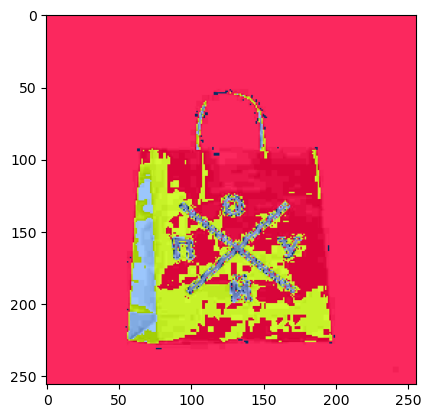

In [ ]:
i = 0
for img, label in dloader:
    plt.imshow((img[i].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
    plt.show()
    i = i + 1
    break

#### Test

In [ ]:
copy_files(PATH_IMAGES_TEST_CLS, PATH_IMAGES_TEST, df)

In [ ]:
image_datasets_test = datasets.ImageFolder(PATH_IMAGES_TEST_CLS, transform=tc)
dloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
i = 0
for img, label in dloader_test:
    plt.imshow((img[i].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
    plt.show()
    i = i + 1
    break

# Data preparation and Feature engineering

## Добавим эмбеддинги от изображений

### Train

In [ ]:
# Models for emb imgs
# https://pytorch.org/vision/stable/models.html#classification

In [ ]:
#  @title resnet18
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet18.to(device)
df_img = _get_img_embed(model_resnet18, 'avgpool', dloader, device, 'resnet18', image_datasets)
assert df['product_id'].dtypes == df_img['product_id'].dtypes
df_img = get_df_img_emb(df_img, 'resnet18')
df = df.merge(df_img, how='inner', left_on='product_id', right_on='product_id')
df.shape

In [ ]:
# @title alexnet
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alexnet.to(device)
df_img = _get_img_embed(model_alexnet, 'avgpool', dloader, device, 'alexnet', image_datasets)
assert df['product_id'].dtypes == df_img['product_id'].dtypes
df_img = get_df_img_emb(df_img, 'alexnet')
df = df.merge(df_img, how='inner', left_on='product_id', right_on='product_id')
df.shape

In [ ]:
# @title resnet34
model_resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_resnet34.to(device)
df_img = _get_img_embed(model_resnet34, 'avgpool', dloader, device, 'resnet34', image_datasets)
assert df['product_id'].dtypes == df_img['product_id'].dtypes
df_img = get_df_img_emb(df_img, 'resnet34')
df = df.merge(df_img, how='inner', left_on='product_id', right_on='product_id')
df.shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 712/712 [13:33<00:00,  1.14s/it]


(91120, 1047)

### Test

In [ ]:
#  @title resnet18
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet18.to(device)
df_img = _get_img_embed(model_resnet18, 'avgpool', dloader_test, device, 'resnet18', image_datasets_test)
assert df_test['product_id'].dtypes == df_img['product_id'].dtypes
df_img = get_df_img_emb(df_img, 'resnet18')
df_test = df_test.merge(df_img, how='inner', left_on='product_id', right_on='product_id')
df_test.shape

In [ ]:
# @title alexnet
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alexnet.to(device)
df_img = _get_img_embed(model_alexnet, 'avgpool', dloader_test, device, 'alexnet', image_datasets_test)
assert df_test['product_id'].dtypes == df_img['product_id'].dtypes
df_img = get_df_img_emb(df_img, 'alexnet')
df_test = df_test.merge(df_img, how='inner', left_on='product_id', right_on='product_id')
df_test.shape

In [ ]:
# @title resnet34
model_resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_resnet34.to(device)
df_img = _get_img_embed(model_resnet34, 'avgpool', dloader_test, device, 'resnet34', image_datasets_test)
assert df_test['product_id'].dtypes == df_img['product_id'].dtypes
df_img = get_df_img_emb(df_img, 'resnet34')
df_test = df_test.merge(df_img, how='inner', left_on='product_id', right_on='product_id')
df_test.shape

## Добавим эмбеддинги от текстовых признаков

In [ ]:
models = ['sberbank-ai/ruRoberta-large', 'sberbank-ai/sbert_large_nlu_ru', 
          'sberbank-ai/sbert_large_mt_nlu_ru', 'sberbank-ai/ruBert-large', 
          'sberbank-ai/ruBert-base', 'cointegrated/rubert-tiny2', "cointegrated/rubert-tiny"
          'DeepPavlov/rubert-base-cased-conversational', 'cointegrated/LaBSE-en-ru', 
          'microsoft/mdeberta-v3-base', 'vicgalle/xlm-roberta-large-xnli-anli', 
          'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli', 'facebook/bart-large-mnli',
          ]

### Train

In [ ]:
# @title 'sberbank-ai/ruBert-large'
model_path = 'sberbank-ai/ruBert-large'
name_model = 'sberbank_ai_ruBert_large'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_sberbank_ai_ruBert_large = AutoModel.from_pretrained(model_path)
model_sberbank_ai_ruBert_large.to(device)

In [ ]:
df_add = get_df_text_emb(df, 'description', model_sberbank_ai_ruBert_large, tokenizer, f'X_description_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'title', model_sberbank_ai_ruBert_large, tokenizer, f'X_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'attributes', model_sberbank_ai_ruBert_large, tokenizer, f'X_attributes_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'shop_title', model_sberbank_ai_ruBert_large, tokenizer, f'X_shop_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
# @title 'cointegrated/rubert-tiny'
model_path = 'cointegrated/rubert-tiny'
name_model = 'cointegrated_rubert_tiny'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_cointegrated_rubert_tiny = AutoModel.from_pretrained(model_path)
model_cointegrated_rubert_tiny.to(device)

In [ ]:
df_add = get_df_text_emb(df, 'description', model_cointegrated_rubert_tiny, tokenizer, f'X_description_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'title', model_cointegrated_rubert_tiny, tokenizer, f'X_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'attributes', model_cointegrated_rubert_tiny, tokenizer, f'X_attributes_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'shop_title', model_cointegrated_rubert_tiny, tokenizer, f'X_shop_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
# @title 'sberbank-ai/ruBert-base'
model_path = 'sberbank-ai/ruBert-base'
name_model = 'model_sberbank_ai_ruBert_base'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_sberbank_ai_ruBert_base = AutoModel.from_pretrained(model_path)
model_sberbank_ai_ruBert_base.to(device)

In [ ]:
df_add = get_df_text_emb(df, 'description', model_sberbank_ai_ruBert_base, tokenizer, f'X_description_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'title', model_sberbank_ai_ruBert_base, tokenizer, f'X_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'attributes', model_sberbank_ai_ruBert_base, tokenizer, f'X_attributes_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'shop_title', model_sberbank_ai_ruBert_base, tokenizer, f'X_shop_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
# @title 'DeepPavlov/rubert-base-cased-conversational'
model_path = 'DeepPavlov/rubert-base-cased-conversational'
name_model = 'DeepPavlov_rubert_base_cased_conversational'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_DeepPavlov_rubert_base_cased_conversational = AutoModel.from_pretrained(model_path)
model_DeepPavlov_rubert_base_cased_conversational.to(device)

In [ ]:
df_add = get_df_text_emb(df, 'description', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_description_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'title', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'attributes', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_attributes_{name_model}', 512)
df = df.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df, 'shop_title', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_shop_title_{name_model}', 128)
df = df.reset_index(drop=True).join(df_add)

### Test

In [ ]:
# @title 'sberbank-ai/ruBert-large'
model_path = 'sberbank-ai/ruBert-large'
name_model = 'sberbank_ai_ruBert_large'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_sberbank_ai_ruBert_large = AutoModel.from_pretrained(model_path)
model_sberbank_ai_ruBert_large.to(device)

In [ ]:
df_add = get_df_text_emb(df_test, 'description', model_sberbank_ai_ruBert_large, tokenizer, f'X_description_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'title', model_sberbank_ai_ruBert_large, tokenizer, f'X_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'attributes', model_sberbank_ai_ruBert_large, tokenizer, f'X_attributes_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'shop_title', model_sberbank_ai_ruBert_large, tokenizer, f'X_shop_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
# @title 'cointegrated/rubert-tiny'
model_path = 'cointegrated/rubert-tiny'
name_model = 'cointegrated_rubert_tiny'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_cointegrated_rubert_tiny = AutoModel.from_pretrained(model_path)
model_cointegrated_rubert_tiny.to(device)

In [ ]:
df_add = get_df_text_emb(df_test, 'description', model_cointegrated_rubert_tiny, tokenizer, f'X_description_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'title', model_cointegrated_rubert_tiny, tokenizer, f'X_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'attributes', model_cointegrated_rubert_tiny, tokenizer, f'X_attributes_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'shop_title', model_cointegrated_rubert_tiny, tokenizer, f'X_shop_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
# @title 'sberbank-ai/ruBert-base'
model_path = 'sberbank-ai/ruBert-base'
name_model = 'model_sberbank_ai_ruBert_base'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_sberbank_ai_ruBert_base = AutoModel.from_pretrained(model_path)
model_sberbank_ai_ruBert_base.to(device)

In [ ]:
df_add = get_df_text_emb(df_test, 'description', model_sberbank_ai_ruBert_base, tokenizer, f'X_description_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'title', model_sberbank_ai_ruBert_base, tokenizer, f'X_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'attributes', model_sberbank_ai_ruBert_base, tokenizer, f'X_attributes_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'shop_title', model_sberbank_ai_ruBert_base, tokenizer, f'X_shop_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
# @title 'DeepPavlov/rubert-base-cased-conversational'
model_path = 'DeepPavlov/rubert-base-cased-conversational'
name_model = 'DeepPavlov_rubert_base_cased_conversational'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_DeepPavlov_rubert_base_cased_conversational = AutoModel.from_pretrained(model_path)
model_DeepPavlov_rubert_base_cased_conversational.to(device)

In [ ]:
df_add = get_df_text_emb(df_test, 'description', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_description_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'title', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'attributes', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_attributes_{name_model}', 512)
df_test = df_test.reset_index(drop=True).join(df_add)

In [ ]:
df_add = get_df_text_emb(df_test, 'shop_title', model_DeepPavlov_rubert_base_cased_conversational, tokenizer, f'X_shop_title_{name_model}', 128)
df_test = df_test.reset_index(drop=True).join(df_add)

## Save df to file

In [ ]:
df.to_csv('train.csv', index=False)

In [ ]:
df_test.to_csv('test.csv', index=False)